# Combined Google-GloFAS trigger - reanalysis
<!-- markdownlint-disable MD013 -->
Determine best balance of Google and GloFAS forecasts to maximize accuracy and leadtime.

For simplicity, just doing now with reanalysis.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [63]:
import ocha_stratus as stratus
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from tqdm.auto import tqdm

from src.datasources import glofas, grrr
from src.constants import *
from src.utils import rp_calc

## Load data

### GloFAS

In [3]:
df_gf = glofas.load_glofas_reanalysis(station_name="wuroboki")

In [4]:
df_gf = df_gf.rename(columns={"time": "valid_time"})

In [5]:
df_gf

,valid_time,dis24
0,1979-01-01,79.656250
1,1979-01-02,77.609375
2,1979-01-03,76.515625
3,1979-01-04,75.671875
4,1979-01-05,74.843750
...,...,...
16736,2024-10-27,1411.625000
16737,2024-10-28,1280.859375
16738,2024-10-29,1156.441406
16739,2024-10-30,1043.812500


### Floodscan

In [6]:
df_fs_raw = stratus.load_parquet_from_blob(
    f"{PROJECT_PREFIX}/processed/floodscan/fs_benue_pixels_1998_2024.parquet"
)
df_fs = (
    df_fs_raw.groupby("date")["SFED"]
    .mean()
    .reset_index()
    .rename(columns={"date": "valid_time"})
)

In [7]:
df_fs

,valid_time,SFED
0,1998-01-12,0.0
1,1998-01-13,0.0
2,1998-01-14,0.0
3,1998-01-15,0.0
4,1998-01-16,0.0
...,...,...
9846,2024-12-27,0.0
9847,2024-12-28,0.0
9848,2024-12-29,0.0
9849,2024-12-30,0.0


### Google

In [10]:
ds_ra = grrr.load_reanalysis()
df_grrr = grrr.process_reanalysis(ds_ra)

In [11]:
df_grrr

,valid_time,streamflow
0,1980-01-01,79.368141
1,1980-01-02,78.400146
2,1980-01-03,77.353523
3,1980-01-04,76.434906
4,1980-01-05,75.629478
...,...,...
16058,2023-12-19,145.726746
16059,2023-12-20,144.114655
16060,2023-12-21,142.627792
16061,2023-12-22,141.002579


## Process

In [12]:
df_compare = df_gf.merge(df_fs).merge(df_grrr)

In [13]:
df_compare["year"] = df_compare["valid_time"].dt.year

In [14]:
df_yearly_max = (
    df_compare.groupby("year").max().drop(columns=["valid_time"]).reset_index()
)

Determine dates of peak for each indicator.

In [15]:
for col in ["dis24", "SFED", "streamflow"]:
    df_yearly_max[f"{col}_maxdate"] = df_compare.loc[
        df_compare.groupby("year").idxmax()[col]
    ]["valid_time"].values

Leadtime between peaks.

In [16]:
for col in ["dis24", "streamflow"]:
    df_yearly_max[f"{col}_peak_leadtime"] = (
        df_yearly_max["SFED_maxdate"] - df_yearly_max[f"{col}_maxdate"]
    )

Return periods.

In [17]:
for col in ["dis24", "SFED", "streamflow"]:
    df_yearly_max = rp_calc.calculate_one_group_rp(
        df_yearly_max, col_name=col, ascending=False
    )

Set whether to target each year, depending on return period severity.

This is admittedly not the best way to do this (would be easier filtering by ranks later), but will leave it for now because the rest of the code was already set up for this format.

In [18]:
rp_targets = [3, 4, 5]

In [19]:
for rp_target in rp_targets:
    df_yearly_max[f"{rp_target}yr_target"] = (
        df_yearly_max["SFED_rp"] >= rp_target
    )

In [20]:
df_yearly_max

,year,dis24,SFED,streamflow,dis24_maxdate,SFED_maxdate,streamflow_maxdate,dis24_peak_leadtime,streamflow_peak_leadtime,dis24_rank,dis24_rp,SFED_rank,SFED_rp,streamflow_rank,streamflow_rp,3yr_target,4yr_target,5yr_target
0,1998,4300.250000,0.142014,1328.853149,1998-09-03,1998-09-29,1998-10-06,26 days,-7 days,3,9.000000,9,3.000000,4,6.750000,True,False,False
1,1999,5244.656250,0.192214,1545.005493,1999-09-11,1999-10-21,1999-10-17,40 days,4 days,2,13.500000,5,5.400000,2,13.500000,True,True,True
2,2000,2863.234375,0.112231,762.573181,2000-09-07,2000-09-02,2000-10-06,-5 days,-34 days,8,3.375000,14,1.928571,24,1.125000,False,False,False
3,2001,2399.468750,0.061692,1064.437988,2001-09-20,2001-09-17,2001-10-04,-3 days,-17 days,13,2.076923,25,1.080000,8,3.375000,False,False,False
4,2002,1854.218750,0.093438,956.879333,2002-09-19,2002-09-24,2002-09-16,5 days,8 days,22,1.227273,18,1.500000,11,2.454545,False,False,False
5,2003,3312.015625,0.151862,953.153015,2003-09-19,2003-09-21,2003-09-30,2 days,-9 days,4,6.750000,7,3.857143,12,2.250000,True,False,False
6,2004,1856.578125,0.035491,801.753296,2004-09-07,2004-09-11,2004-09-26,4 days,-15 days,21,1.285714,26,1.038462,20,1.350000,False,False,False
7,2005,2077.328125,0.082421,903.818298,2005-08-15,2005-08-23,2005-10-07,8 days,-45 days,19,1.421053,23,1.173913,15,1.800000,False,False,False
8,2006,1733.757812,0.113096,847.273560,2006-09-23,2006-09-16,2006-09-17,-7 days,-1 days,23,1.173913,13,2.076923,18,1.500000,False,False,False
9,2007,2235.781250,0.103586,836.369751,2007-09-22,2007-09-12,2007-09-11,-10 days,1 days,17,1.588235,15,1.800000,19,1.421053,False,False,False


Quick comparing peak leadtimes. As expected GloFAS is quite early.

<Axes: xlabel='year'>

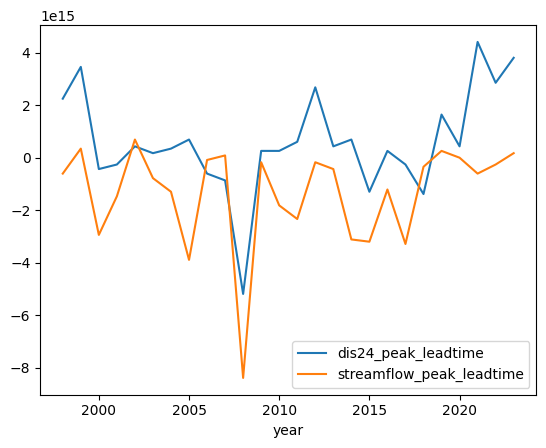

In [21]:
df_yearly_max.set_index("year")[
    [f"{x}_peak_leadtime" for x in ["dis24", "streamflow"]]
].plot()

Check against severity of flooding. Slight positive relationship? Which is good, because this means that the more severe flooding is, the earlier we will be.

<Axes: xlabel='SFED'>

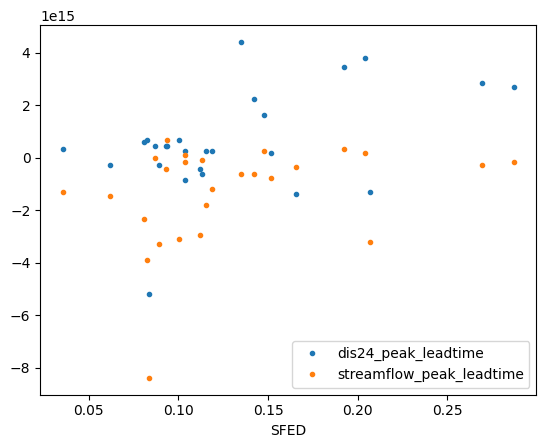

In [22]:
df_yearly_max.set_index("SFED")[
    [f"{x}_peak_leadtime" for x in ["dis24", "streamflow"]]
].plot(marker=".", linewidth=0)

In [23]:
df_in = pd.DataFrame(columns=["year"])

for rp_target in rp_targets:
    dicts = []
    thresh_fs = df_yearly_max[df_yearly_max[f"{rp_target}yr_target"]][
        "SFED"
    ].min()
    for year, group in df_fs.groupby(df_fs["valid_time"].dt.year):
        dff = group[group["SFED"] >= thresh_fs]
        if not dff.empty:
            dicts.append(
                {
                    "year": year,
                    f"SFED_{rp_target}yr_thresh_date": dff["valid_time"].min(),
                }
            )
    df_in_rp = pd.DataFrame(dicts)
    df_in = df_in.merge(df_in_rp, how="outer")


df_yearly_max = df_yearly_max.merge(df_in, how="left")

Clunky way to do this, but determining the first day that the target RP threshold would've been reached (i.e., the day our target flooding starts).

In [24]:
# to avoid divide by zero warnings
np.seterr(divide="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Iterate

Iterate over all possible combinations of GloFAS and Google forecast thresholds. Also iterate over the target RPs.

In [25]:
total_years = len(df_yearly_max)
ranks = range(total_years + 1)

dicts = []
dfs_yearly = []

for gf_rank in tqdm(ranks):
    if gf_rank > 0:
        thresh_gf = df_yearly_max.set_index("dis24_rank").loc[gf_rank]["dis24"]
    else:
        thresh_gf = np.inf
    for gr_rank in ranks:
        if gr_rank > 0:
            thresh_gr = df_yearly_max.set_index("streamflow_rank").loc[
                gr_rank
            ]["streamflow"]
        else:
            thresh_gr = np.inf
        dff = df_yearly_max[
            (df_yearly_max["dis24_rank"] <= gf_rank)
            | (df_yearly_max["streamflow_rank"] <= gr_rank)
        ]
        dff_daily = df_compare[
            (df_compare["dis24"] >= thresh_gf)
            | (df_compare["streamflow"] >= thresh_gr)
        ]
        pp_daily = dff_daily["year"].nunique()
        df_trig_dates = (
            dff_daily.groupby("year")["valid_time"]
            .min()
            .reset_index()
            .rename(columns={"valid_time": "trig_date"})
        )
        dff = dff.merge(df_trig_dates, how="left")
        for ind_name, thresh in zip(
            ["dis24", "streamflow"], [thresh_gf, thresh_gr]
        ):
            dff_daily_ind = df_compare[df_compare[ind_name] >= thresh]
            df_trig_dates_ind = (
                dff_daily_ind.groupby("year")["valid_time"]
                .min()
                .reset_index()
                .rename(columns={"valid_time": f"{ind_name}_trig_date"})
            )
            dff = dff.merge(df_trig_dates_ind, how="left")
        dff["leadtime_peak"] = dff["SFED_maxdate"] - dff["trig_date"]
        for rp_target in rp_targets:
            dff[f"leadtime_{rp_target}yr_target"] = (
                dff[f"SFED_{rp_target}yr_thresh_date"] - dff["trig_date"]
            )

            p = df_yearly_max[f"{rp_target}yr_target"].sum()
            pp = len(dff)
            # just double check that the two ways to calculate
            # positives agree
            assert pp_daily == pp
            tp = dff[f"{rp_target}yr_target"].sum()
            fp = pp - tp
            tpr = tp / p
            ppv = tp / (tp + fp)
            f1 = 2 * ppv * tpr / (ppv + tpr)
            dicts.append(
                {
                    "rp_target": rp_target,
                    "rp_gf": np.divide((total_years + 1), gf_rank),
                    "rp_gr": np.divide((total_years + 1), gr_rank),
                    "rp_combined": np.divide((total_years + 1), pp),
                    "tpr": tpr,
                    "lt": dff[f"leadtime_{rp_target}yr_target"].mean(),
                    "f1": f1,
                    "lt_peak": dff[dff[f"{rp_target}yr_target"]][
                        "leadtime_peak"
                    ].mean(),
                }
            )
        dff["rp_gf"] = np.divide((total_years + 1), gf_rank)
        dff["rp_gr"] = np.divide((total_years + 1), gr_rank)
        dfs_yearly.append(dff)

df_rps = pd.DataFrame(dicts)

df_rps

  0%|          | 0/27 [00:00<?, ?it/s]

,rp_target,rp_gf,rp_gr,rp_combined,tpr,lt,f1,lt_peak
0,3,inf,inf,inf,0.000000,NaT,NaN,NaT
1,4,inf,inf,inf,0.000000,NaT,NaN,NaT
2,5,inf,inf,inf,0.000000,NaT,NaN,NaT
3,3,inf,27.000000,27.000000,0.111111,-28 days +00:00:00,0.200000,-3 days +00:00:00
4,4,inf,27.000000,27.000000,0.166667,-26 days +00:00:00,0.285714,-3 days +00:00:00
...,...,...,...,...,...,...,...,...
2182,4,1.038462,1.080000,1.038462,1.000000,33 days 08:00:00,0.375000,42 days 20:00:00
2183,5,1.038462,1.080000,1.038462,1.000000,38 days 14:24:00,0.322581,46 days 09:36:00
2184,3,1.038462,1.038462,1.038462,1.000000,39 days 02:40:00,0.514286,49 days 16:00:00
2185,4,1.038462,1.038462,1.038462,1.000000,34 days 00:00:00,0.375000,43 days 12:00:00


In [26]:
# set this to grab values easily later
df_all_simulations = pd.concat(dfs_yearly, ignore_index=True)

In [27]:
# set probabilities
for x in ["gr", "gf", "combined"]:
    df_rps[f"prob_{x}"] = 1 / df_rps[f"rp_{x}"]

Come up with a measure `rel_prob_gr` that represents the balance between Google and GloFAS. When it is 1, we always trigger with Google (never with GloFAS), and when it is -1, we always trigger with GloFAS (never with Google).

In [28]:
df_rps["rel_prob_gr"] = (df_rps["prob_gr"] - df_rps["prob_gf"]) / df_rps[
    "prob_combined"
]

df_rps

,rp_target,rp_gf,rp_gr,rp_combined,tpr,lt,f1,lt_peak,prob_gr,prob_gf,prob_combined,rel_prob_gr
0,3,inf,inf,inf,0.000000,NaT,NaN,NaT,0.000000,0.000000,0.000000,NaN
1,4,inf,inf,inf,0.000000,NaT,NaN,NaT,0.000000,0.000000,0.000000,NaN
2,5,inf,inf,inf,0.000000,NaT,NaN,NaT,0.000000,0.000000,0.000000,NaN
3,3,inf,27.000000,27.000000,0.111111,-28 days +00:00:00,0.200000,-3 days +00:00:00,0.037037,0.000000,0.037037,1.000000
4,4,inf,27.000000,27.000000,0.166667,-26 days +00:00:00,0.285714,-3 days +00:00:00,0.037037,0.000000,0.037037,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2182,4,1.038462,1.080000,1.038462,1.000000,33 days 08:00:00,0.375000,42 days 20:00:00,0.925926,0.962963,0.962963,-0.038462
2183,5,1.038462,1.080000,1.038462,1.000000,38 days 14:24:00,0.322581,46 days 09:36:00,0.925926,0.962963,0.962963,-0.038462
2184,3,1.038462,1.038462,1.038462,1.000000,39 days 02:40:00,0.514286,49 days 16:00:00,0.962963,0.962963,0.962963,0.000000
2185,4,1.038462,1.038462,1.038462,1.000000,34 days 00:00:00,0.375000,43 days 12:00:00,0.962963,0.962963,0.962963,0.000000


## Plots

In [29]:
def plot_metrics_rel_prob(
    rp_target: int,
    plot_metric: str,
    peak_lt: bool = False,
    max_plot_rp: int = 5,
    min_plot_rp: int = 3,
):
    """Plot accuracy metrics and leadtime for multiple overall RPs"""
    lt_col = "lt_peak" if peak_lt else "lt"
    df_plot = df_rps[
        (df_rps["rp_combined"] <= max_plot_rp)
        & (df_rps["rp_combined"] >= min_plot_rp)
        & (df_rps["rp_target"] == rp_target)
    ]

    fig, ax = plt.subplots(dpi=200, figsize=(7, 7))
    ax2 = ax.twinx()

    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for i, (rp_combined, group) in enumerate(df_plot.groupby("rp_combined")):
        group = group.sort_values("rel_prob_gr")
        color = color_cycle[
            i % len(color_cycle)
        ]  # cycle through colors safely

        ax.plot(
            group["rel_prob_gr"],
            group[plot_metric],
            label=f"{rp_combined:.1f}",
            color=color,
            linestyle="-",
        )
        ax2.plot(
            group["rel_prob_gr"],
            group[lt_col].dt.days,
            color=color,
            linestyle="--",
        )

    # Only add legend for rp_combined once (from ax)
    ax.legend(
        title="Overall RP (years)\nsolid: accuracy metric\ndashed: leadtime",
        bbox_to_anchor=(1.1, 1),
        loc="upper left",
    )
    ax.axvline(0, color="lightgrey", linewidth=0.5, linestyle="--")

    # Labels
    ax.set_xlabel(
        "Relative probability of activating\n"
        "<-- more likely with GloFAS              more likely with Google -->"
    )
    ax.set_ylabel(plot_metric.upper())
    lt_label = "peak flooding" if peak_lt else "target flooding threshold"
    ax2.set_ylabel(f"Leadtime to {lt_label} (days)")
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, 1])
    ax2.set_ylim([0, 40])
    ax.set_title(
        f"GloFAS/Google comparison, target {rp_target}-yr RP flooding\n"
        "solid: accruacy metric, dashed: leadtime"
    )

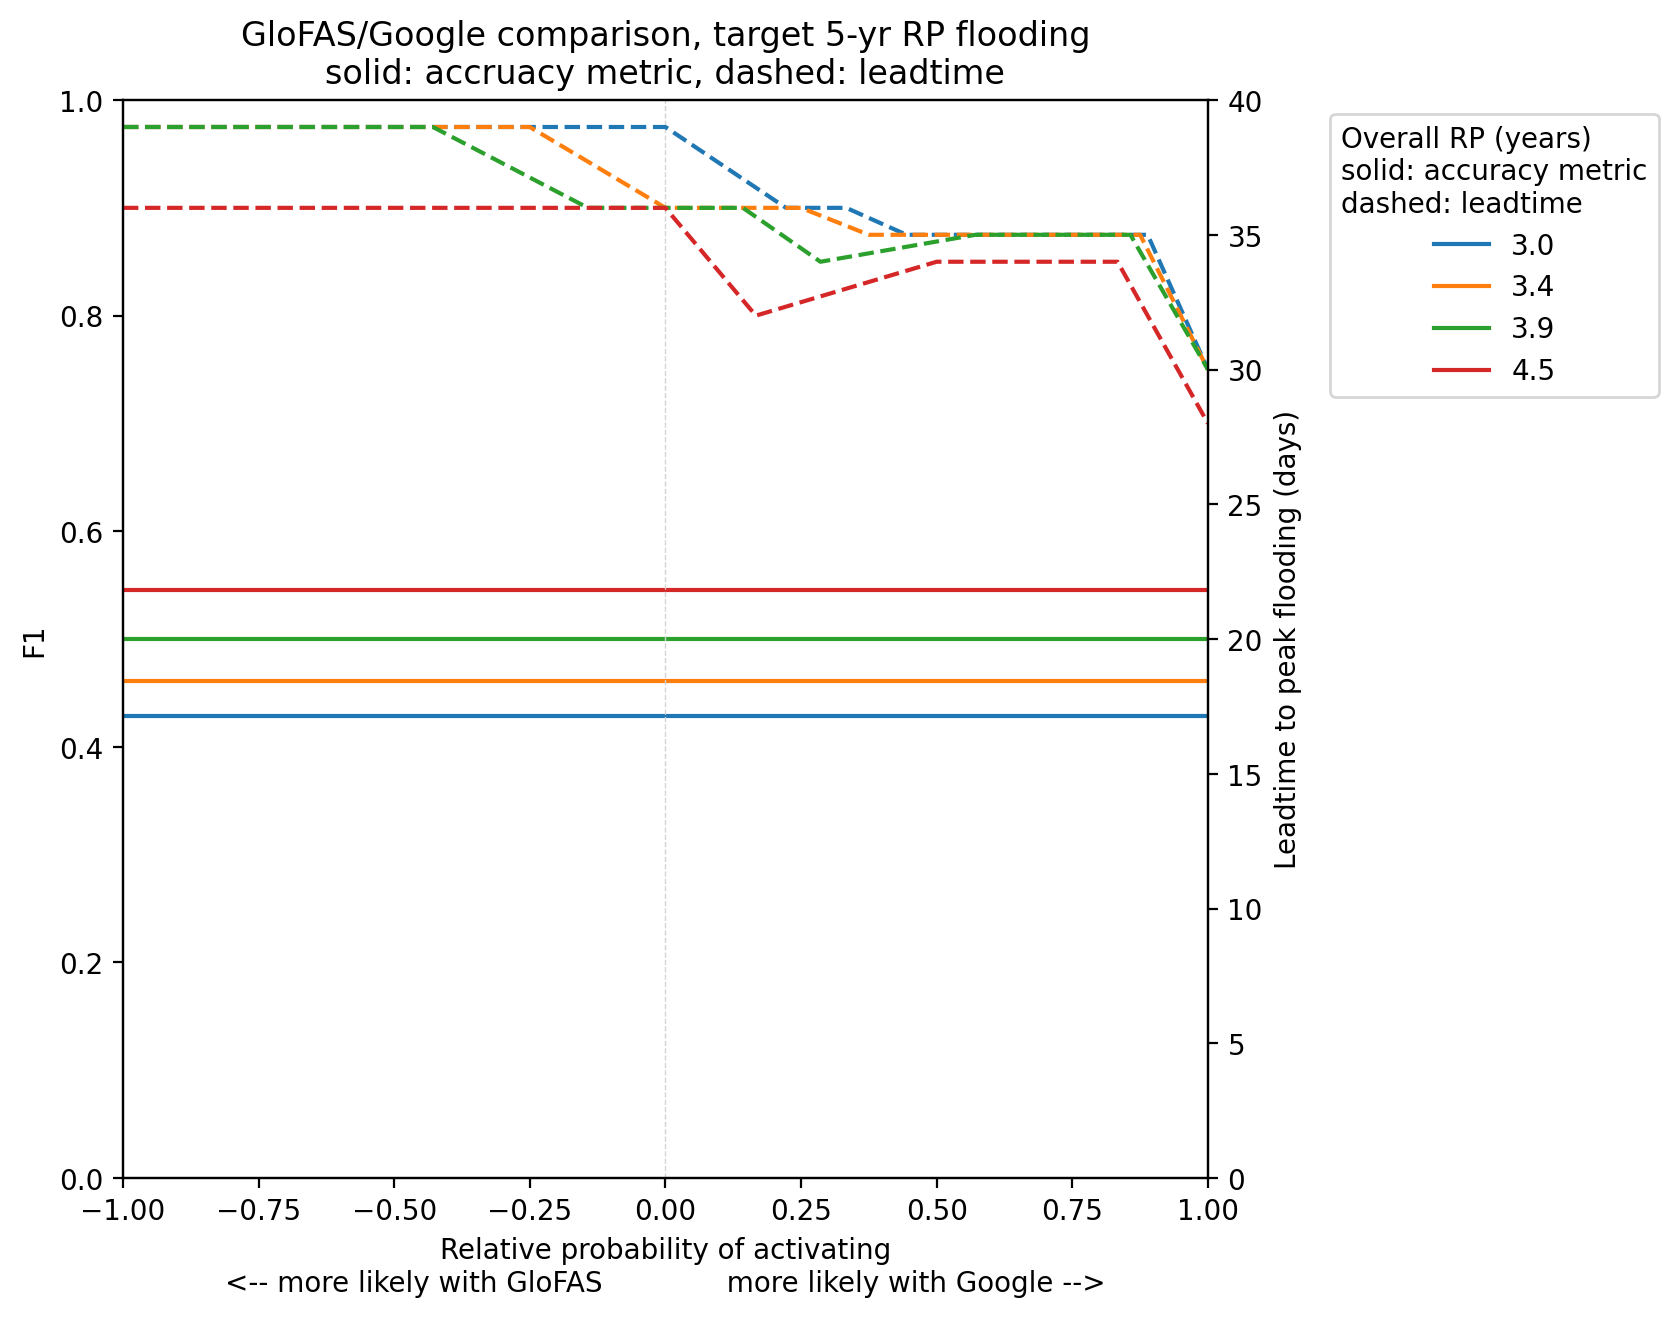

In [30]:
plot_metrics_rel_prob(5, "f1", peak_lt=True)

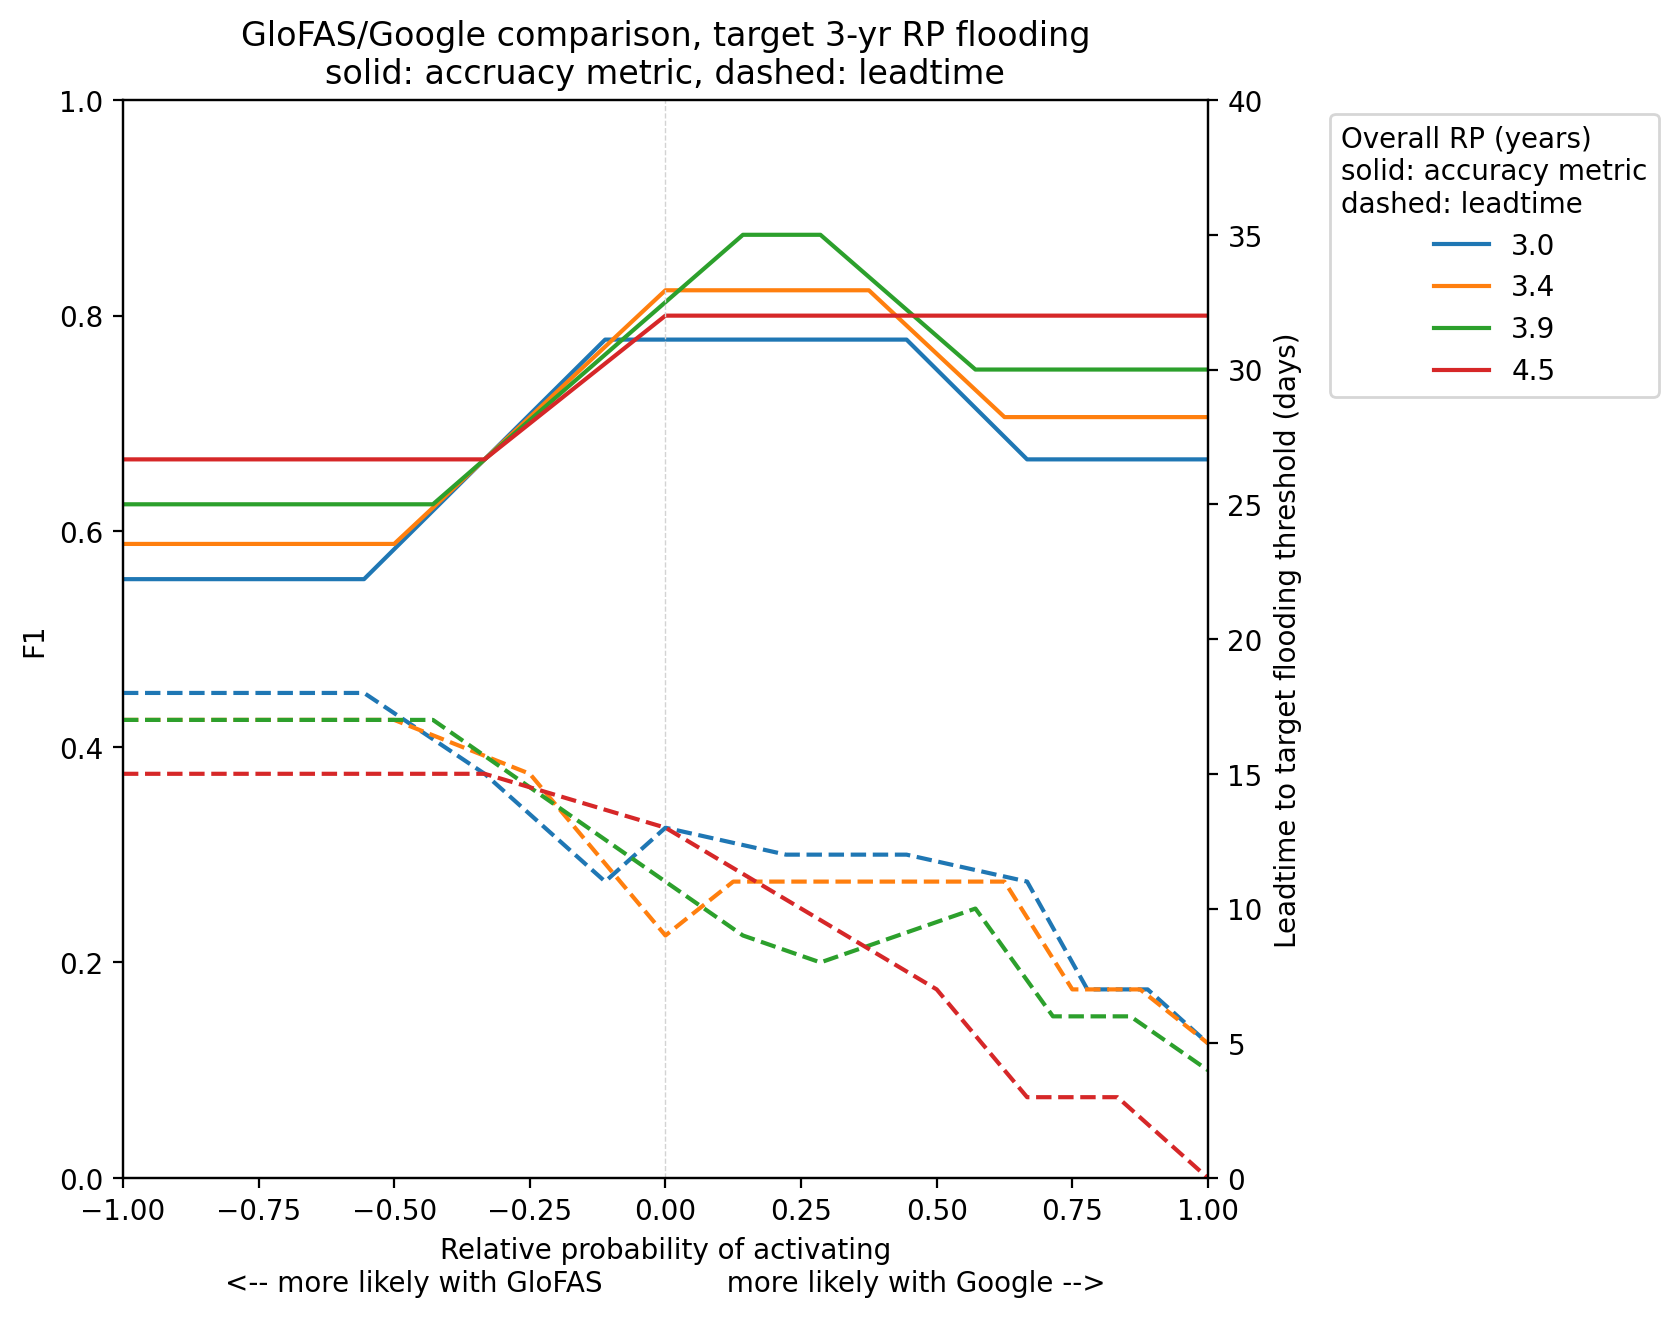

In [31]:
plot_metrics_rel_prob(3, "f1", peak_lt=False)

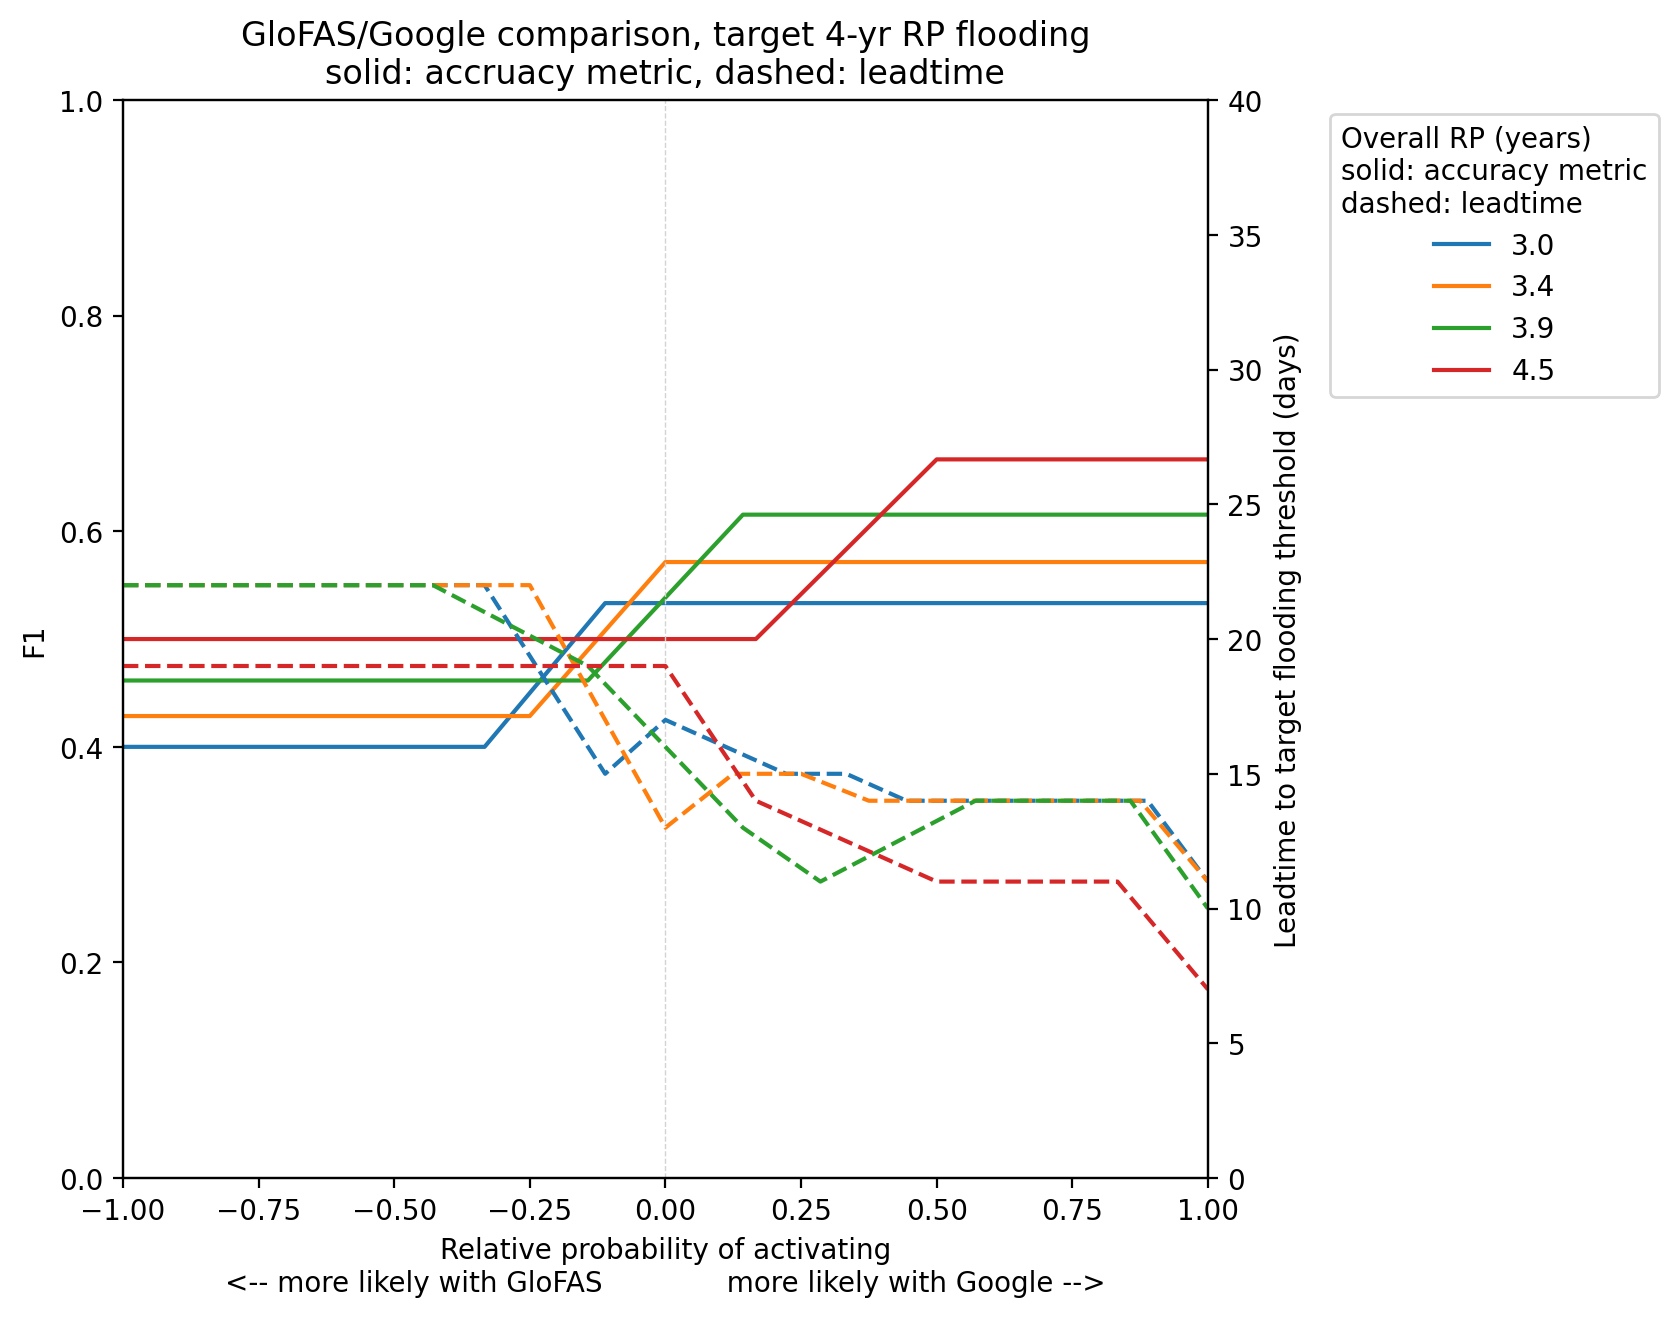

In [32]:
plot_metrics_rel_prob(4, "f1", peak_lt=False)

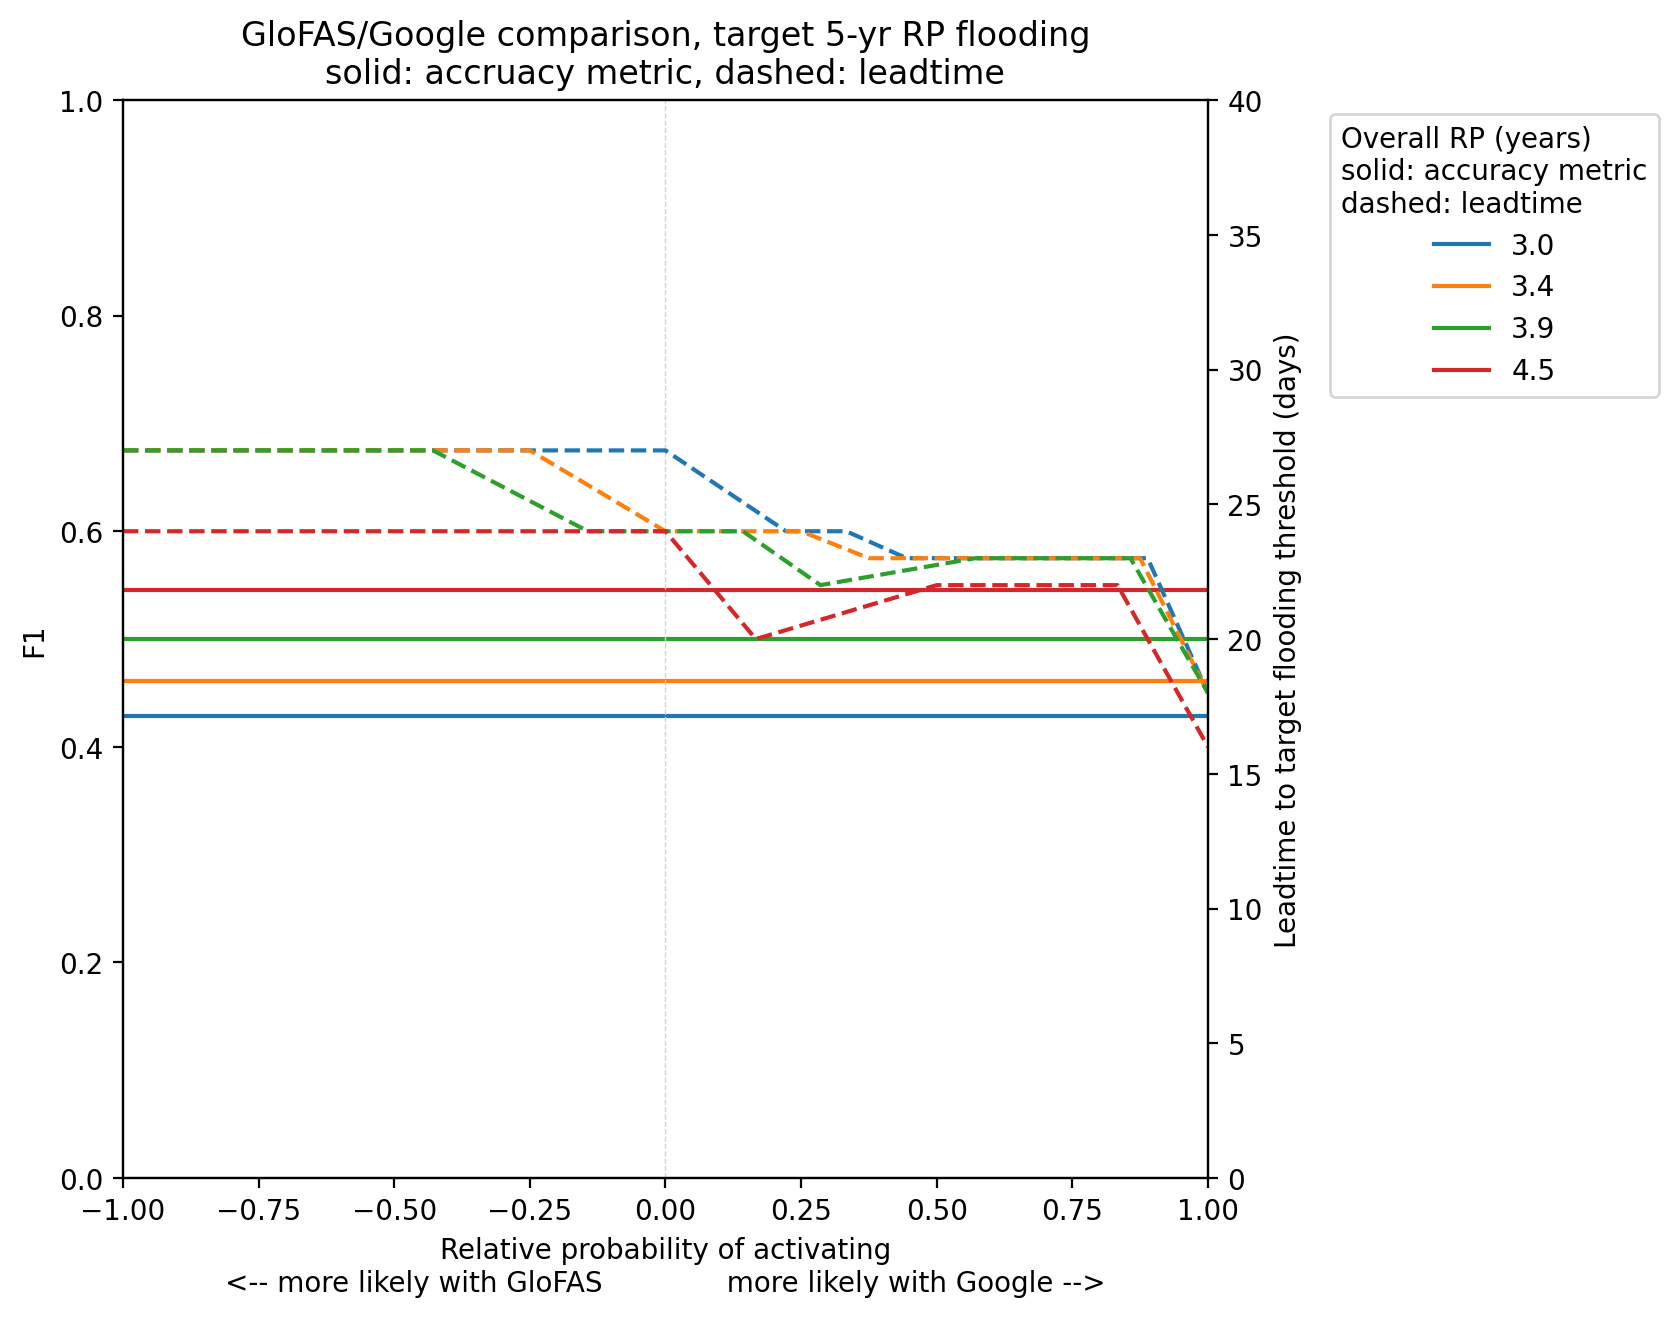

In [33]:
plot_metrics_rel_prob(5, "f1", peak_lt=False)

### Specific overall RP

Look at only the overall RP specified by CERF (4.5 years).

In [34]:
# df_rps_acceptable = df_rps[
#     (df_rps["rp_combined"] <= 5) & (df_rps["rp_combined"] >= 3)
# ]
acceptable_rp = (total_years + 1) / 6
df_rps_acceptable = df_rps[df_rps["rp_combined"] == acceptable_rp].copy()

In [35]:
df_rps_acceptable

,rp_target,rp_gf,rp_gr,rp_combined,tpr,lt,f1,lt_peak,prob_gr,prob_gf,prob_combined,rel_prob_gr
18,3,inf,4.50,4.5,0.666667,0 days 20:00:00,0.800000,15 days 08:00:00,0.222222,0.000000,0.222222,1.000000
19,4,inf,4.50,4.5,0.666667,7 days 12:00:00,0.666667,20 days 12:00:00,0.222222,0.000000,0.222222,1.000000
20,5,inf,4.50,4.5,0.600000,16 days 16:00:00,0.545455,28 days 16:00:00,0.222222,0.000000,0.222222,1.000000
99,3,27.00,4.50,4.5,0.666667,3 days 12:00:00,0.800000,18 days 00:00:00,0.222222,0.037037,0.222222,0.833333
100,4,27.00,4.50,4.5,0.666667,11 days 12:00:00,0.666667,24 days 12:00:00,0.222222,0.037037,0.222222,0.833333
101,5,27.00,4.50,4.5,0.600000,22 days 00:00:00,0.545455,34 days 00:00:00,0.222222,0.037037,0.222222,0.833333
180,3,13.50,4.50,4.5,0.666667,3 days 12:00:00,0.800000,18 days 00:00:00,0.222222,0.074074,0.222222,0.666667
181,4,13.50,4.50,4.5,0.666667,11 days 12:00:00,0.666667,24 days 12:00:00,0.222222,0.074074,0.222222,0.666667
182,5,13.50,4.50,4.5,0.600000,22 days 00:00:00,0.545455,34 days 00:00:00,0.222222,0.074074,0.222222,0.666667
261,3,9.00,4.50,4.5,0.666667,7 days 08:00:00,0.800000,21 days 20:00:00,0.222222,0.111111,0.222222,0.500000


In [36]:
def plot_metrics_one_overallrp(
    plot_metric: str,
    peak_lt: bool = False,
):
    lt_col = "lt_peak" if peak_lt else "lt"
    df_plot = df_rps_acceptable.copy()

    fig, ax = plt.subplots(dpi=200, figsize=(7, 7))
    ax2 = ax.twinx()

    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for i, (rp_target, group) in enumerate(df_plot.groupby("rp_target")):
        group = group.sort_values("rel_prob_gr")
        color = color_cycle[
            i % len(color_cycle)
        ]  # cycle through colors safely

        ax.plot(
            group["rel_prob_gr"],
            group[plot_metric],
            label=rp_target,
            color=color,
            linestyle="-",
        )
        ax2.plot(
            group["rel_prob_gr"],
            group[lt_col].dt.days,
            color=color,
            linestyle="--",
        )

    # Only add legend for rp_combined once (from ax)
    ax.legend(
        title="Target RP (years)\nsolid: accuracy metric\ndashed: leadtime",
        bbox_to_anchor=(1.1, 1),
        loc="upper left",
    )
    ax.axvline(0, color="lightgrey", linewidth=0.5, linestyle="--")

    # Labels
    ax.set_xlabel(
        "Relative probability of activating\n"
        "<-- more likely with GloFAS              more likely with Google -->"
    )
    ax.set_ylabel(plot_metric.upper())
    lt_label = "peak flooding" if peak_lt else "target flooding threshold"
    ax2.set_ylabel(f"Leadtime to {lt_label} (days)")
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, 1])
    ax2.set_ylim([0, 40])
    ax.set_title(
        f"GloFAS/Google comparison, overall {acceptable_rp:.1f}-yr RP\n"
        "solid: accruacy metric, dashed: leadtime"
    )

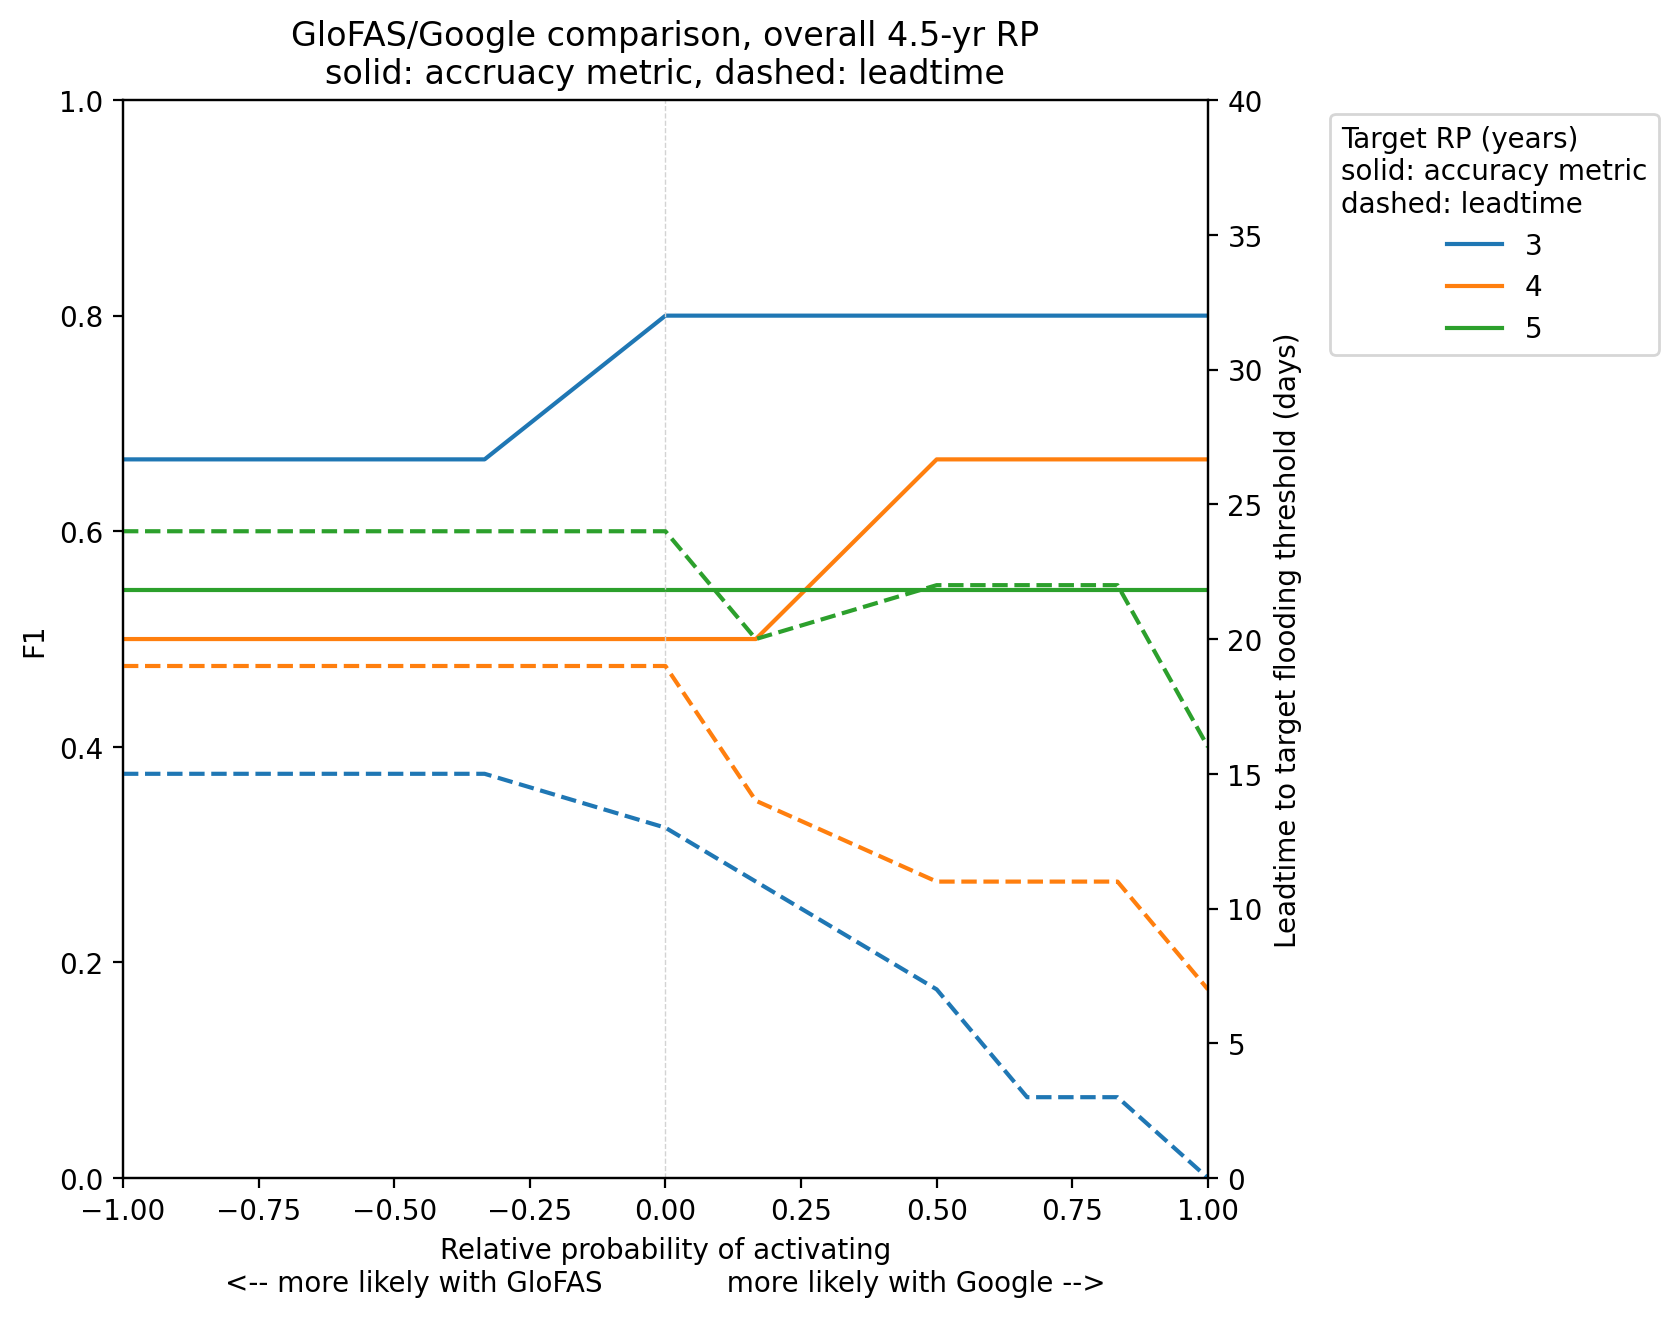

In [37]:
plot_metrics_one_overallrp("f1")

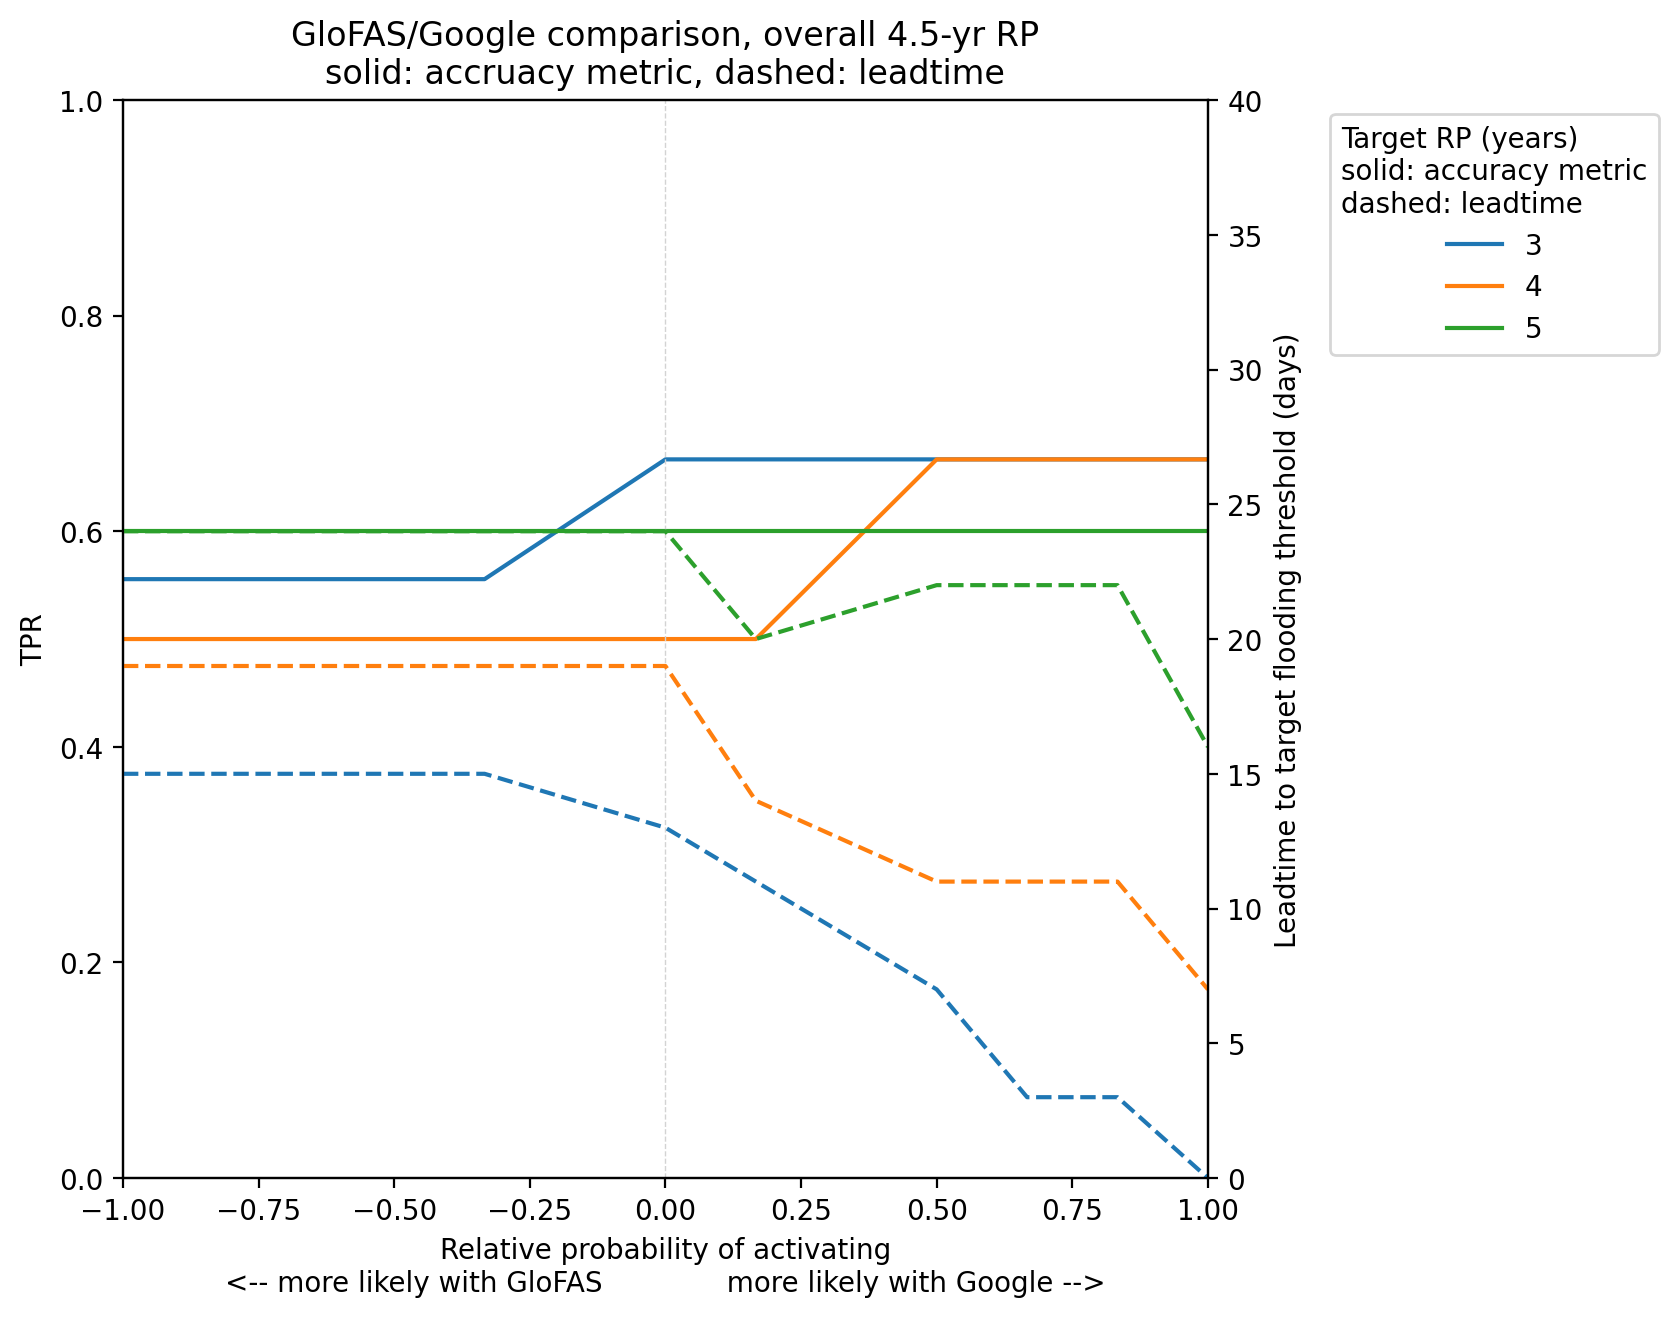

In [38]:
plot_metrics_one_overallrp("tpr")

## Specific combination

Pick specification combination based on accuracy metrics. Looks like a balanced trigger (equal probability to activate with both) seems to provide decent combination of accuracy and leadtime. We can then look at the historical performance in more detail.

In [39]:
df_rps_acceptable[df_rps_acceptable["rel_prob_gr"] == 0]

,rp_target,rp_gf,rp_gr,rp_combined,tpr,lt,f1,lt_peak,prob_gr,prob_gf,prob_combined,rel_prob_gr
420,3,5.4,5.4,4.5,0.666667,13 days 16:00:00,0.800000,26 days 00:00:00,0.185185,0.185185,0.222222,0.0
421,4,5.4,5.4,4.5,0.500000,19 days 08:00:00,0.500000,36 days 16:00:00,0.185185,0.185185,0.222222,0.0
422,5,5.4,5.4,4.5,0.600000,24 days 16:00:00,0.545455,36 days 16:00:00,0.185185,0.185185,0.222222,0.0


In [40]:
# based on reading of above df, we want individual RPs 5.4 years
df_selected_trigger = df_all_simulations[
    (df_all_simulations["rp_gf"] == 5.4) & (df_all_simulations["rp_gr"] == 5.4)
]

In [41]:
df_selected_trigger = df_yearly_max.merge(df_selected_trigger, how="outer")

In [42]:
rp_target = 5

Get actual thresholds

In [57]:
df_selected_trigger.sort_values("dis24", ascending=False)

,year,dis24,SFED,streamflow,dis24_maxdate,SFED_maxdate,streamflow_maxdate,dis24_peak_leadtime,streamflow_peak_leadtime,dis24_rank,...,SFED_5yr_thresh_date,trig_date,dis24_trig_date,streamflow_trig_date,leadtime_peak,leadtime_3yr_target,leadtime_4yr_target,leadtime_5yr_target,rp_gf,rp_gr
24,2022,5347.171875,0.269161,1793.780396,2022-08-19,2022-09-21,2022-09-24,33 days,-3 days,1,...,2022-09-10,2022-08-19,2022-08-19,2022-09-04,33 days,8 days,10 days,22 days,5.4,5.4
1,1999,5244.656250,0.192214,1545.005493,1999-09-11,1999-10-21,1999-10-17,40 days,4 days,2,...,1999-10-21,1999-09-05,1999-09-05,1999-09-10,46 days,27 days,43 days,46 days,5.4,5.4
0,1998,4300.250000,0.142014,1328.853149,1998-09-03,1998-09-29,1998-10-06,26 days,-7 days,3,...,NaT,1998-08-19,1998-08-19,1998-09-28,41 days,41 days,NaT,NaT,5.4,5.4
5,2003,3312.015625,0.151862,953.153015,2003-09-19,2003-09-21,2003-09-30,2 days,-9 days,4,...,NaT,2003-09-19,2003-09-19,NaT,2 days,1 days,NaT,NaT,5.4,5.4
14,2012,3110.078125,0.286909,1394.855469,2012-08-21,2012-09-21,2012-09-23,31 days,-2 days,5,...,2012-08-27,2012-08-21,2012-08-21,2012-09-02,31 days,2 days,5 days,6 days,5.4,5.4
12,2010,3109.257812,0.115183,1100.995361,2010-09-07,2010-09-10,2010-10-01,3 days,-21 days,6,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN
16,2014,2918.125000,0.100249,926.234802,2014-08-23,2014-08-31,2014-10-06,8 days,-36 days,7,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN
2,2000,2863.234375,0.112231,762.573181,2000-09-07,2000-09-02,2000-10-06,-5 days,-34 days,8,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN
10,2008,2627.976562,0.083352,1063.593872,2008-08-27,2008-06-28,2008-10-03,-60 days,-97 days,9,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN
20,2018,2547.906250,0.165637,1157.043457,2018-09-28,2018-09-12,2018-09-16,-16 days,-4 days,10,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN


In [59]:
df_selected_trigger.columns

Index(['year', 'dis24', 'SFED', 'streamflow', 'dis24_maxdate', 'SFED_maxdate',
       'streamflow_maxdate', 'dis24_peak_leadtime', 'streamflow_peak_leadtime',
       'dis24_rank', 'dis24_rp', 'SFED_rank', 'SFED_rp', 'streamflow_rank',
       'streamflow_rp', '3yr_target', '4yr_target', '5yr_target',
       'SFED_3yr_thresh_date', 'SFED_4yr_thresh_date', 'SFED_5yr_thresh_date',
       'trig_date', 'dis24_trig_date', 'streamflow_trig_date', 'leadtime_peak',
       'leadtime_3yr_target', 'leadtime_4yr_target', 'leadtime_5yr_target',
       'rp_gf', 'rp_gr'],
      dtype='object')

In [58]:
df_selected_trigger.sort_values("streamflow", ascending=False)

,year,dis24,SFED,streamflow,dis24_maxdate,SFED_maxdate,streamflow_maxdate,dis24_peak_leadtime,streamflow_peak_leadtime,dis24_rank,...,SFED_5yr_thresh_date,trig_date,dis24_trig_date,streamflow_trig_date,leadtime_peak,leadtime_3yr_target,leadtime_4yr_target,leadtime_5yr_target,rp_gf,rp_gr
24,2022,5347.171875,0.269161,1793.780396,2022-08-19,2022-09-21,2022-09-24,33 days,-3 days,1,...,2022-09-10,2022-08-19,2022-08-19,2022-09-04,33 days,8 days,10 days,22 days,5.4,5.4
1,1999,5244.656250,0.192214,1545.005493,1999-09-11,1999-10-21,1999-10-17,40 days,4 days,2,...,1999-10-21,1999-09-05,1999-09-05,1999-09-10,46 days,27 days,43 days,46 days,5.4,5.4
14,2012,3110.078125,0.286909,1394.855469,2012-08-21,2012-09-21,2012-09-23,31 days,-2 days,5,...,2012-08-27,2012-08-21,2012-08-21,2012-09-02,31 days,2 days,5 days,6 days,5.4,5.4
0,1998,4300.250000,0.142014,1328.853149,1998-09-03,1998-09-29,1998-10-06,26 days,-7 days,3,...,NaT,1998-08-19,1998-08-19,1998-09-28,41 days,41 days,NaT,NaT,5.4,5.4
21,2019,2440.054688,0.147553,1212.237061,2019-10-11,2019-10-30,2019-10-27,19 days,3 days,12,...,NaT,2019-10-27,NaT,2019-10-27,3 days,3 days,NaT,NaT,5.4,5.4
20,2018,2547.906250,0.165637,1157.043457,2018-09-28,2018-09-12,2018-09-16,-16 days,-4 days,10,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN
12,2010,3109.257812,0.115183,1100.995361,2010-09-07,2010-09-10,2010-10-01,3 days,-21 days,6,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN
3,2001,2399.468750,0.061692,1064.437988,2001-09-20,2001-09-17,2001-10-04,-3 days,-17 days,13,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN
10,2008,2627.976562,0.083352,1063.593872,2008-08-27,2008-06-28,2008-10-03,-60 days,-97 days,9,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN
18,2016,2364.773438,0.118837,969.453369,2016-09-22,2016-09-25,2016-10-09,3 days,-14 days,15,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN


In [55]:
for x in ["dis24", "streamflow"]:
    thresh = df_selected_trigger[
        ~df_selected_trigger[f"{x}_trig_date"].isnull()
    ][x].min()
    print(x, thresh)

dis24 3110.0781
streamflow 1212.237


### True positives

In [159]:
dff = df_selected_trigger[
    (df_selected_trigger[f"{rp_target}yr_target"])
    & (~df_selected_trigger["rp_gf"].isnull())
]

for _, row in dff.iterrows():
    print(row)
    print()

year                                       1999
dis24                                5244.65625
SFED                                   0.192214
streamflow                          1545.005493
dis24_maxdate               1999-09-11 00:00:00
SFED_maxdate                1999-10-21 00:00:00
streamflow_maxdate          1999-10-17 00:00:00
dis24_peak_leadtime            40 days 00:00:00
streamflow_peak_leadtime        4 days 00:00:00
dis24_rank                                    2
dis24_rp                                   13.5
SFED_rank                                     5
SFED_rp                                     5.4
streamflow_rank                               2
streamflow_rp                              13.5
3yr_target                                 True
4yr_target                                 True
5yr_target                                 True
SFED_3yr_thresh_date        1999-10-02 00:00:00
SFED_4yr_thresh_date        1999-10-18 00:00:00
SFED_5yr_thresh_date        1999-10-21 0

### False positives

In [44]:
dff = df_selected_trigger[
    (~df_selected_trigger[f"{rp_target}yr_target"])
    & (~df_selected_trigger["rp_gf"].isnull())
]

for _, row in dff.iterrows():
    print(row)
    print()

year                                       1998
dis24                                   4300.25
SFED                                   0.142014
streamflow                          1328.853149
dis24_maxdate               1998-09-03 00:00:00
SFED_maxdate                1998-09-29 00:00:00
streamflow_maxdate          1998-10-06 00:00:00
dis24_peak_leadtime            26 days 00:00:00
streamflow_peak_leadtime      -7 days +00:00:00
dis24_rank                                    3
dis24_rp                                    9.0
SFED_rank                                     9
SFED_rp                                     3.0
streamflow_rank                               4
streamflow_rp                              6.75
3yr_target                                 True
4yr_target                                False
5yr_target                                False
SFED_3yr_thresh_date        1998-09-29 00:00:00
SFED_4yr_thresh_date                        NaT
SFED_5yr_thresh_date                    

### False negatives

In [45]:
dff = df_selected_trigger[
    (df_selected_trigger[f"{rp_target}yr_target"])
    & (df_selected_trigger["rp_gf"].isnull())
]

for _, row in dff.iterrows():
    print(row)
    print()

year                                       2015
dis24                               1563.804688
SFED                                    0.20691
streamflow                           738.006592
dis24_maxdate               2015-09-20 00:00:00
SFED_maxdate                2015-09-05 00:00:00
streamflow_maxdate          2015-10-12 00:00:00
dis24_peak_leadtime          -15 days +00:00:00
streamflow_peak_leadtime     -37 days +00:00:00
dis24_rank                                   26
dis24_rp                               1.038462
SFED_rank                                     3
SFED_rp                                     9.0
streamflow_rank                              25
streamflow_rp                              1.08
3yr_target                                 True
4yr_target                                 True
5yr_target                                 True
SFED_3yr_thresh_date        2015-09-01 00:00:00
SFED_4yr_thresh_date        2015-09-02 00:00:00
SFED_5yr_thresh_date        2015-09-04 0

### True negatives

In [46]:
dff = df_selected_trigger[
    (~df_selected_trigger[f"{rp_target}yr_target"])
    & (df_selected_trigger["rp_gf"].isnull())
]

for _, row in dff.iterrows():
    print(row)
    print()

year                                       2000
dis24                               2863.234375
SFED                                   0.112231
streamflow                           762.573181
dis24_maxdate               2000-09-07 00:00:00
SFED_maxdate                2000-09-02 00:00:00
streamflow_maxdate          2000-10-06 00:00:00
dis24_peak_leadtime           -5 days +00:00:00
streamflow_peak_leadtime     -34 days +00:00:00
dis24_rank                                    8
dis24_rp                                  3.375
SFED_rank                                    14
SFED_rp                                1.928571
streamflow_rank                              24
streamflow_rp                             1.125
3yr_target                                False
4yr_target                                False
5yr_target                                False
SFED_3yr_thresh_date                        NaT
SFED_4yr_thresh_date                        NaT
SFED_5yr_thresh_date                    

### Timeline

Plot historical timing of trigger and flood extent severities.

First check average leadtimes of specific indicators:

In [152]:
df_selected_trigger["dis24_5yr_leadtime"] = (
    df_selected_trigger["SFED_5yr_thresh_date"]
    - df_selected_trigger["dis24_trig_date"]
)

In [154]:
df_selected_trigger["dis24_5yr_leadtime"].mean()

Timedelta('24 days 16:00:00')

In [156]:
df_selected_trigger["streamflow_5yr_leadtime"] = (
    df_selected_trigger["SFED_5yr_thresh_date"]
    - df_selected_trigger["streamflow_trig_date"]
)

In [157]:
df_selected_trigger["streamflow_5yr_leadtime"].mean()

Timedelta('13 days 16:00:00')

In [158]:
df_selected_trigger["leadtime_5yr_target"].mean()

Timedelta('24 days 16:00:00')

Create plot showing when each year both triggers would have been met, and when flood extent reached 3-, 4-, and 5-yr RP severity, as well as yearly maximum.

In [129]:
df_plot = df_selected_trigger.copy()

/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_54954/3368475269.py:107: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


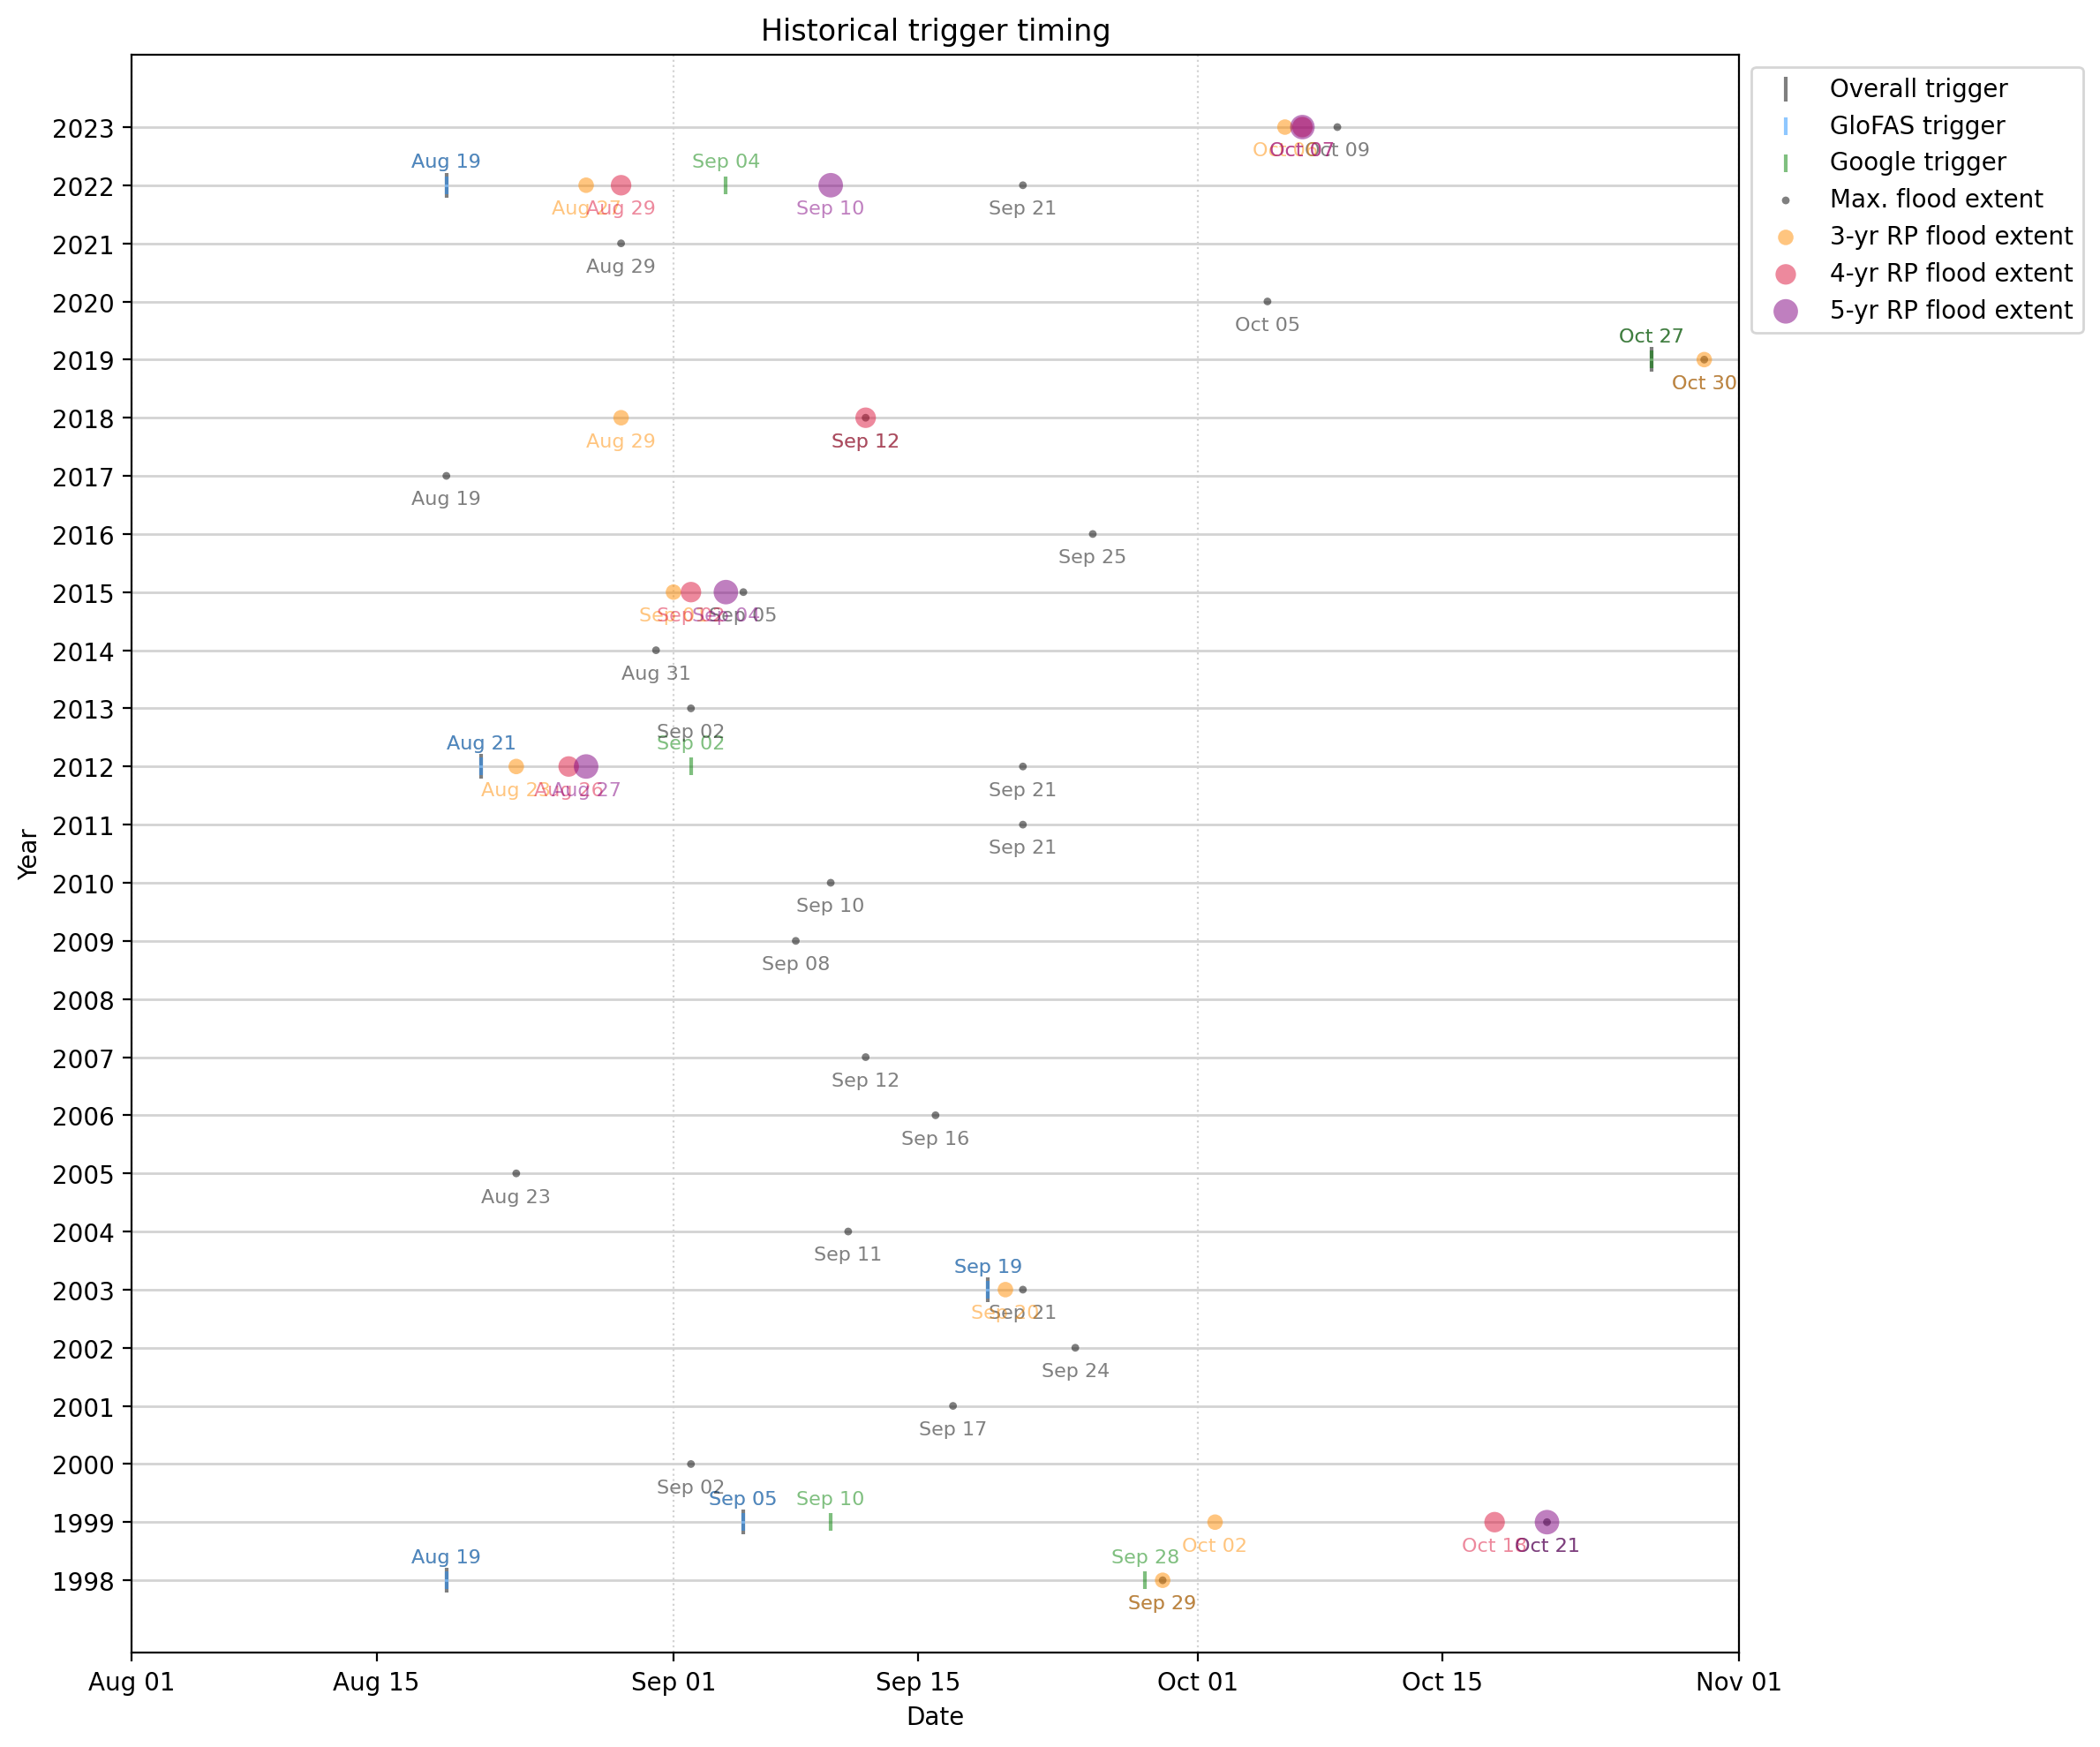

In [149]:
# Ensure datetime format
date_cols = [
    "trig_date",
    "dis24_trig_date",
    "streamflow_trig_date",
    "SFED_3yr_thresh_date",
    "SFED_4yr_thresh_date",
    "SFED_5yr_thresh_date",
    "SFED_maxdate",
]
# df_plot[date_cols] = df_plot[date_cols].apply(pd.to_datetime)


# Normalize to fixed year for x-axis alignment
def normalize_date(dt):
    if pd.isnull(dt):
        return None
    return dt.replace(year=2000)


for col in date_cols:
    df_plot[f"{col}_norm"] = df_plot[col].apply(normalize_date)

# Define full style config for each date column
# Format: col_name -> (color, label, marker, size, zorder, annotate_above_line)
date_styles = {
    "trig_date_norm": ("black", "Overall trigger", "|", 100, -2, False),
    "dis24_trig_date_norm": (
        "dodgerblue",
        "GloFAS trigger",
        "|",
        50,
        5,
        False,
    ),
    "streamflow_trig_date_norm": (
        "green",
        "Google trigger",
        "|",
        50,
        5,
        False,
    ),
    "SFED_maxdate_norm": ("k", "Max. flood extent", "o", 10, 4, True),
    "SFED_3yr_thresh_date_norm": (
        "darkorange",
        "3-yr RP flood extent",
        "o",
        40,
        4,
        True,
    ),
    "SFED_4yr_thresh_date_norm": (
        "crimson",
        "4-yr RP flood extent",
        "o",
        70,
        4,
        True,
    ),
    "SFED_5yr_thresh_date_norm": (
        "purple",
        "5-yr RP flood extent",
        "o",
        100,
        4,
        True,
    ),
}

# Setup plot
fig, ax = plt.subplots(figsize=(12, 10), dpi=200)
years_sorted = sorted(df_plot["year"].unique(), reverse=True)
y_positions = {year: i for i, year in enumerate(years_sorted)}
plotted_labels = set()

# Draw timelines
for _, row in df_plot.iterrows():
    y = y_positions[row["year"]]

    # Horizontal baseline
    ax.hlines(
        y,
        pd.Timestamp("2000-08-01"),
        pd.Timestamp("2000-11-01"),
        color="lightgray",
        linewidth=1,
    )

    # Plot and annotate each date
    for col_norm, (
        color,
        label,
        marker,
        size,
        zorder,
        annotate_above,
    ) in date_styles.items():
        date_val = row.get(col_norm)
        if pd.notnull(date_val):
            # Plot marker
            show_label = label if label not in plotted_labels else None
            ax.scatter(
                date_val,
                y,
                facecolor=color,
                edgecolor="none",
                s=size,
                marker=marker,
                zorder=zorder,
                label=show_label,
                alpha=0.5,
            )
            if show_label:
                plotted_labels.add(label)

            # Format label date
            label_text = date_val.strftime("%b %d")
            offset = 0.4 if annotate_above else -0.4
            ax.annotate(
                label_text,
                (date_val, y + offset),
                ha="center",
                va="center",
                fontsize=8,
                color=color,
                alpha=0.5,
            )

# Add vertical lines for month boundaries
for month_start in pd.date_range("2000-08-01", "2000-11-01", freq="MS"):
    ax.axvline(month_start, color="lightgray", linestyle=":", linewidth=0.8)

# Axes formatting
ax.set_yticks(list(y_positions.values()))
ax.set_yticklabels(list(y_positions.keys()))
ax.set_ylabel("Year")
ax.set_xlabel("Date")
ax.set_title("Historical trigger timing")
ax.invert_yaxis()

# X-axis date formatting
ax.set_xlim(pd.Timestamp("2000-08-01"), pd.Timestamp("2000-11-01"))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper left",
    bbox_to_anchor=(1, 1),
)

plt.tight_layout()
plt.show()